In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage import measure
import csv
from collections import defaultdict
import time
import tracemalloc
import os
import psutil
from functools import wraps

### Performance
---

To evaluate the algorithm using [wrapper](https://stackoverflow.com/questions/36610950/passing-kwargs-received-in-a-wrapper-function-definition-to-arguments-of-an-e).  
- tracemalloc to monitor memory, obtain [peak](https://discuss.pytorch.org/t/measuring-peak-memory-usage-tracemalloc-for-pytorch/34067) [link2](https://stackoverflow.com/questions/70525623/measuring-the-allocated-memory-with-tracemalloc)
- time for [time](https://stackoverflow.com/questions/66036844/time-time-or-time-perf-counter-which-is-faster) [link 2](https://superfastpython.com/time-time-vs-time-perf_counter/), Accuracy: time.perf_counter() is generally more accurate than time.time(), using a processor performance counter with the highest available resolution.
- os for CPU cycles

In [2]:
class PerformanceGauge:
    metrics = []

    @classmethod
    def add_metric(cls, func_name,time, cpu_cycles, memory_usage,approx_peak):
        cls.metrics.append({
            'function': func_name,
            'time_took': time,
            'cpu_cycles': cpu_cycles,
            'memory_usage': memory_usage,
            'memory_peak': approx_peak,
        })

    @classmethod
    def get_metrics(cls):
        return cls.metrics

def measure_performance(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        process = psutil.Process()
        
        # Initial measures
        start_cpu = os.times().user
        tracemalloc.start()
        start_memory = process.memory_info().rss / 1048576  # En MB
        start_time = time.perf_counter()

        result = func(*args, **kwargs)

        # Final metrics
        end_time = time.perf_counter()
        end_cpu = os.times().user
        end_memory = process.memory_info().rss / 1048576  # En MB
        current, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        
        cpu_time = end_cpu - start_cpu
        memory_usage = end_memory - start_memory
        duration = end_time - start_time
        approx_peak=peak / 10**6
        # Save metrics
        PerformanceGauge.add_metric(func.__name__, duration,cpu_time, memory_usage,approx_peak )
        return result
    return wrapper
    

## Preprocess Image
---
1. Loads the image directly in grayscale. It is a simple and fast conversion
2. Enhances the local contrast in the image:
> Using a medium-size tileGridSize for a contrast that is neither too local nor too global.
> Using a medium-size clipLimit to increase the contrast, but it is not a high value so as not to cause excessive noise, but keep in mind that some people can be seen incompletely or far away, so a low value does not work.

3. Apply Gaussian: We want to reduce noise, but since the people are small silhouettes, we don't want their details to disappear, so we set the kernel smaller. The standard deviation is set to 0 for automatic adjustment. This setting consists of OpenCV calculating a value based on the kernel size, balancing smoothing and detail preservation.
4. Maintain detail in darker areas while controlling the effect of the overexposed regions. thresh 127 is balanced, if it is smaller it causes overexposure, and if it is larger it causes more “noise”.

In [3]:
def load_image(image_name, show_image=False): 
    image_path = f"data/{image_name}" 
    image = cv2.imread(image_path, cv2.IMREAD_COLOR) 
    if image is None: 
        print(f"The image cannot be loaded: {image_path}") 
        return None 
    if show_image: 
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) 
        plt.title('Loaded Image') 
        plt.show() 
    return image 
 
def clahe(image: np.ndarray, show_image=False, clip_limit=2.0, grid_size=(8, 8)) -> np.ndarray: 
    """Contrast-limited adaptive histogram equalization.""" 
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=grid_size) 
    clahe_image = clahe.apply(image) 
    if show_image: 
        plt.imshow(clahe_image, cmap='gray') 
        plt.title('CLAHE Image') 
        plt.show() 
    return clahe_image 

def convert_to_lab(image: np.ndarray) -> np.ndarray:
    return cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

def apply_clahe_to_lab(lab_image: np.ndarray, show_image=False) -> np.ndarray:
    l, a, b = cv2.split(lab_image)
    l_clahe = clahe(l, show_image)
    lab_clahe = cv2.merge((l_clahe, a, b))
    return cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)

def apply_truncated_threshold(image: np.ndarray, show_image=False) -> np.ndarray:
    blurred_image = cv2.GaussianBlur(image, (3, 3), 0)
    _, r_channel = cv2.threshold(blurred_image[:, :, 2], 127, 255, cv2.THRESH_TRUNC)
    _, g_channel = cv2.threshold(blurred_image[:, :, 1], 127, 255, cv2.THRESH_TRUNC)
    _, b_channel = cv2.threshold(blurred_image[:, :, 0], 127, 255, cv2.THRESH_TRUNC)
    truncated_image = cv2.merge((b_channel, g_channel, r_channel))
    if show_image:
        plt.imshow(cv2.cvtColor(truncated_image, cv2.COLOR_BGR2RGB))
        plt.title('Preprocessed Image')
        plt.show()
    return truncated_image

def preprocess_image(image_name, show_image=False):
    image = load_image(image_name, show_image)
    if image is None:
        return None
    lab_image = convert_to_lab(image)
    clahe_image = apply_clahe_to_lab(lab_image, show_image)
    truncated_image = apply_truncated_threshold(clahe_image, show_image)
    return truncated_image

## Extract differences
---
1. The XOR operator will highlight the differences between the two images, which in this case will be the additional objects on the background
2. Apply opening to remove small noise

In [4]:
def segmentation_foreground(truncated_image, truncated_bckg_image, show_image=False):
    if show_image:
        plt.imshow(bckg_image, cmap='gray')
        plt.title('Background preprocessed')
        plt.show()
    segmented_image = cv2.absdiff(truncated_image,truncated_bckg_image)
    kernel = np.ones((5, 5), np.uint8)  # Aplicar la operación de opening
    opening = cv2.morphologyEx(segmented_image, cv2.MORPH_OPEN, kernel)
    if show_image:
        plt.imshow(opening)
        plt.title('Segmented Foreground')
        plt.show()
    return opening

## Detect edges
---
1. Detect edges and using "adhoc" numbers
2. Enhance edges improve to separate them from the background

In [5]:
def color_edge_detection(image: np.ndarray, show_image=False, min_threshold=100, max_threshold=200):
    # Convert image to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Allowed range of colors black and sand color
    color_ranges = {'black': ((0, 0, 0), (180, 255, 50)), 'sand': ((20, 40, 150), (30, 100, 200))}
    
    edges = np.zeros_like(image[:, :, 0])
    
    for color, (lower, upper) in color_ranges.items():
        mask = cv2.inRange(hsv_image, lower, upper)
        color_edges = cv2.Canny(mask, 100, 200)
        edges = cv2.bitwise_or(edges, color_edges)
    intensified_edges = cv2.Laplacian(edges, cv2.CV_64F)
    laplacian = np.uint8(np.absolute(intensified_edges))
    if show_image:
        plt.imshow(laplacian)
        plt.title('Color Edge Detection')
        plt.show()
    return laplacian

## Obtain person detected coordinates
---
1. Convert image from float64 to 8uint and 1 channel to be used by findContours
2. Obtain contours, and filter by the perimeter size
3. Obtain the center points of the contours

In [6]:
def obtain_contours(image: np.ndarray, show_image=False):
    contours, _ = cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    min_perimeter = 50
    filtered_contours = [cnt for cnt in contours if cv2.arcLength(cnt, True) > min_perimeter]
 
    if show_image:
        contour_image = np.zeros_like(image)
        cv2.drawContours(contour_image, filtered_contours, -1, (255, 255, 255), 1)
        plt.imshow(contour_image, cmap='gray')
        plt.title('Contours')
        plt.show()
    return filtered_contours
def obtain_center_points(filtered_contours):
    y_min = 420
    contour_points = []
    for contorno in filtered_contours:
        M = cv2.moments(contorno)
        if M['m00'] != 0:
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])
            if cy > y_min:
                contour_points.append((cx, cy))
    return contour_points

In [7]:
def color_edge_detection(image: np.ndarray, show_image=False, min_threshold=100, max_threshold=200):
    # Convert image to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Allowed range of colors black and sand color
    color_ranges = {'black': ((0, 0, 0), (180, 255, 50)), 'sand': ((20, 40, 150), (30, 100, 200))}
    
    edges = np.zeros_like(image[:, :, 0])
    
    for color, (lower, upper) in color_ranges.items():
        mask = cv2.inRange(hsv_image, lower, upper)
        color_edges = cv2.Canny(mask, min_threshold, max_threshold)
        edges = cv2.bitwise_or(edges, color_edges)
    intensified_edges = cv2.Laplacian(edges, cv2.CV_64F)
    laplacian = np.uint8(np.absolute(intensified_edges))
    if show_image:
        plt.imshow(laplacian, cmap='gray')
        plt.title('Color Edge Detection')
        plt.show()
    return laplacian

In [8]:
@measure_performance
def process_image(image_path, bckg_image, show_image=False):
    binary_image = preprocess_image(image_path, show_image)
    if binary_image is None:
        return None

    segmented_image = segmentation_foreground(binary_image, bckg_image, show_image)
    edges = color_edge_detection(segmented_image, show_image)
    contours = obtain_contours(edges, show_image)
    center_points = obtain_center_points(contours)
    return {
        'image': image_path,
        'count': len(center_points),
        'points': center_points
    }

In [9]:
def process_images(image_names, bckg_image,show_image=False):
    processed_images = []
    for name in image_names:
        processed_image = process_image(name, bckg_image,show_image)
        if processed_image is not None:
            processed_images.append(processed_image)
    return processed_images

## Obtain ground truth data

In [10]:
def read_manual_annotations(input_file,with_headers =False):
    file_path=f"data/{input_file}"
    # Diccionario para almacenar los datos
    data = defaultdict(lambda: {'people_count': 0, 'coordinates': []})
    # No headers
    with open(file_path, 'r', newline='') as csvfile:
        reader = csv.reader(csvfile)
        if with_headers:
            next(reader)
        for row in reader:
            if with_headers:
                label, point_x, point_y, image_name, image_width, image_height=row
                name = image_name
                x = int(point_x)
                y = int(point_y)
            else:  
                # Extract values based on the order: label, x, y, name, height, width
                name = row[3]
                x = int(row[1])
                y = int(row[2])
            data[name]['people_count'] += 1
            data[name]['coordinates'].append((x, y))
    return data

## Validation
---
True Positives (TP):
- A reference point (manual) is considered correctly detected (TP) if there is at least one detection point at a distance of 30 pixels on the Y-axis and 12 pixels on the X-axis.
- Only the detection point closest to the reference point is counted as a TP to avoid inflating the number of TPs.

False Negatives (FN):
- A fiducial point is considered not detected (FN) if there is no detection point within the limits of 30 pixels on the Y-axis and 12 pixels on the X-axis.

False Positive (FP):
- A detection point is considered a false positive (FP) if it is not within the limits of 30 pixels on the Y-axis and 12 pixels on the X-axis of any reference point.

Calculation Steps:
- Initialization: point lists are converted to Numpy arrays and counters for TP, FP and FN are initialized.
- Manual Point Traversal: For each manual point, the closest detection point that meets the distance thresholds in X and Y is searched.
- Closeness Check: If a close detection point is found, the TP counter is incremented and that detection point is marked as used.
- False Negative Detection: If no nearby detection point is found, the FN counter is incremented.
- False Positive Calculation: All unused detection points are counted as FP.

In [11]:
def calculate_tp_fp_fn(manual_points, detected_points, y_thresh=30, x_thresh=12):
    manual_points = np.array(manual_points)
    detected_points = np.array(detected_points)
    tp = 0
    fp = 0
    fn = 0
    detected_used = np.zeros(len(detected_points), dtype=bool)
    for manual_point in manual_points:
        detected = False
        closest_index = None
        closest_distance = float('inf')
        
        for i, detected_point in enumerate(detected_points):
            if not detected_used[i]:
                distance_y = abs(manual_point[1] - detected_point[1])
                distance_x = abs(manual_point[0] - detected_point[0])
                if distance_y <= y_thresh and distance_x <= x_thresh:
                    distance = np.sqrt(distance_y ** 2 + distance_x ** 2)
                    if distance < closest_distance:
                        closest_distance = distance
                        closest_index = i
                        detected = True
        
        if detected and closest_index is not None:
            tp += 1
            detected_used[closest_index] = True
        else:
            fn += 1

    fp = np.sum(~detected_used)

    return tp, fp, fn

Precision: It is the proportion of true positives (TP) over the total positive predictions (TP + FP).  
Recall: It is the proportion of true positives over the total number of instances that are truly positive (TP + FN).  
F1 Score: It is the harmonic mean of accuracy and completeness, and is calculated as follows.

In [12]:
def calculate_F1score_recall_precision(manual_points, detected_points):
    tp, fp, fn=calculate_tp_fp_fn(manual_points,detected_points)
    precision=0
    recall=0
    if tp+fp > 0: 
        precision=tp/(tp+fp)
    if tp+fn>0:
        recall=tp/(tp+fn)
    f1score=0
    if recall > 0 and precision > 0 :   
        f1score=2*((precision*recall)/(precision+recall))
    return precision, recall, f1score
    

In [13]:
def validation(manual_results, results):
    comparison = []
    for result in results:
        image_name = result['image']
        manual_data = manual_results.get(image_name, {'people_count': 0, 'coordinates': []})
        manual_count = manual_data['people_count']
        manual_points = manual_data['coordinates']
        detected_count = result['count']
        detected_points = result['points']
        precision, recall, f1score=calculate_F1score_recall_precision(manual_points,detected_points)
        mse=np.mean((manual_count - detected_count) ** 2)#sustraendo debe ser la predicción
        comparison.append({
            'image': image_name,
            'manual_count': manual_count,
            'detected_count': detected_count,
            'MSE':mse,
            'recall':recall,
            'precision':precision,
            'f1score': f1score
        })
    return comparison

### MAIN
---

In [14]:
manual_path = "manual_annotations.csv"
manual_results = read_manual_annotations(manual_path, True)
bckg_image_name = '1660284000.jpg'
bckg_image = preprocess_image(bckg_image_name)
image_names = ["1660287600.jpg", "1660294800.jpg","1660291200.jpg","1660298400.jpg","1660302000.jpg","1660305600.jpg","1660309200.jpg","1660316400.jpg","1660320000.jpg"]

results = process_images(image_names, bckg_image)
comparison = validation(manual_results, results)
all_metrics = PerformanceGauge.get_metrics()
for metric in all_metrics:
    print(f"Function: {metric['function']}")
    print(f"  Time : {metric['time_took']:.6f} seconds")
    print(f"  CPU cycles: {metric['cpu_cycles']:.6f}")
    print(f"  Memory usage: {metric['memory_usage']:.2f} MB")
    print(f"  Memory peak: {metric['memory_peak']:.2f} MB")
    print("---")
for comp in comparison:
    print(f"Image: {comp['image']}, Manual Count: {comp['manual_count']}, Detected Count: {comp['detected_count']}")
    print(f" MSE Image level: {comp['MSE']}, Recall: {comp['recall']}, precision: {comp['precision']} f1score: {comp['f1score']}")

Function: process_image
  Time : 0.082982 seconds
  CPU cycles: 0.078125
  Memory usage: 2.41 MB
  Memory peak: 60.29 MB
---
Function: process_image
  Time : 0.074854 seconds
  CPU cycles: 0.000000
  Memory usage: -0.11 MB
  Memory peak: 60.14 MB
---
Function: process_image
  Time : 0.073360 seconds
  CPU cycles: 0.062500
  Memory usage: 1.18 MB
  Memory peak: 60.14 MB
---
Function: process_image
  Time : 0.075192 seconds
  CPU cycles: 0.046875
  Memory usage: -0.47 MB
  Memory peak: 60.14 MB
---
Function: process_image
  Time : 0.082775 seconds
  CPU cycles: 0.015625
  Memory usage: -0.78 MB
  Memory peak: 60.14 MB
---
Function: process_image
  Time : 0.078967 seconds
  CPU cycles: 0.015625
  Memory usage: 2.32 MB
  Memory peak: 60.14 MB
---
Function: process_image
  Time : 0.074512 seconds
  CPU cycles: 0.062500
  Memory usage: -0.53 MB
  Memory peak: 60.14 MB
---
Function: process_image
  Time : 0.077005 seconds
  CPU cycles: 0.015625
  Memory usage: 0.08 MB
  Memory peak: 60.14 MB


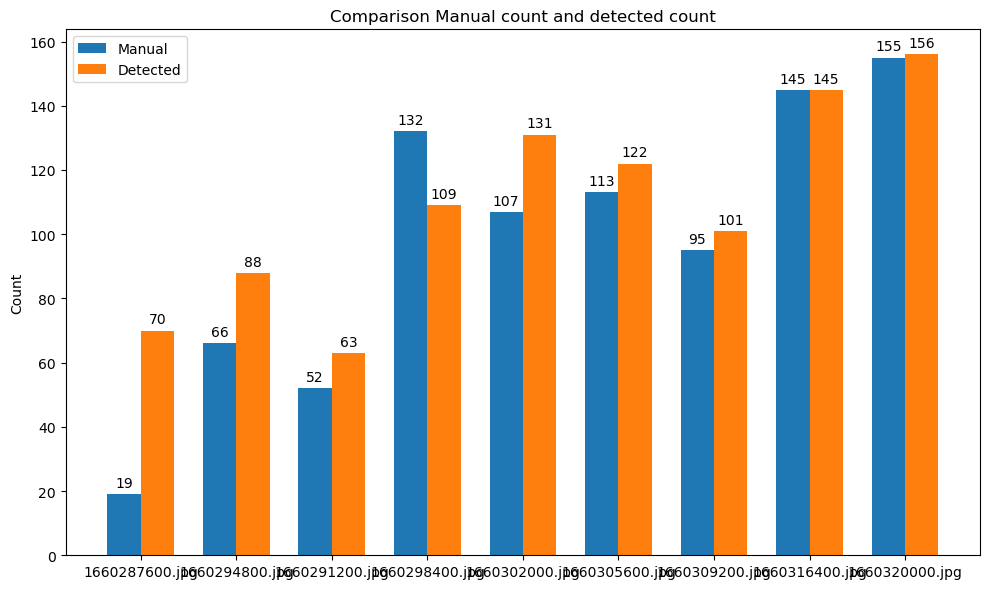

In [15]:

images = [item['image'] for item in comparison]
manual_counts = [item['manual_count'] for item in comparison]
detected_counts = [item['detected_count'] for item in comparison]


x = np.arange(len(images))
width = 0.35

# Crear el gráfico
fig, ax = plt.subplots(figsize=(10, 6))

# Dibujar las barras
rects1 = ax.bar(x - width/2, manual_counts, width, label='Manual')
rects2 = ax.bar(x + width/2, detected_counts, width, label='Detected')

# Personalizar el gráfico
ax.set_ylabel('Count')
ax.set_title('Comparison Manual count and detected count')
ax.set_xticks(x)
ax.set_xticklabels(images)
ax.legend()

# Añadir etiquetas de valor en las barras
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 puntos de desplazamiento vertical
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)


fig.tight_layout()
plt.show()

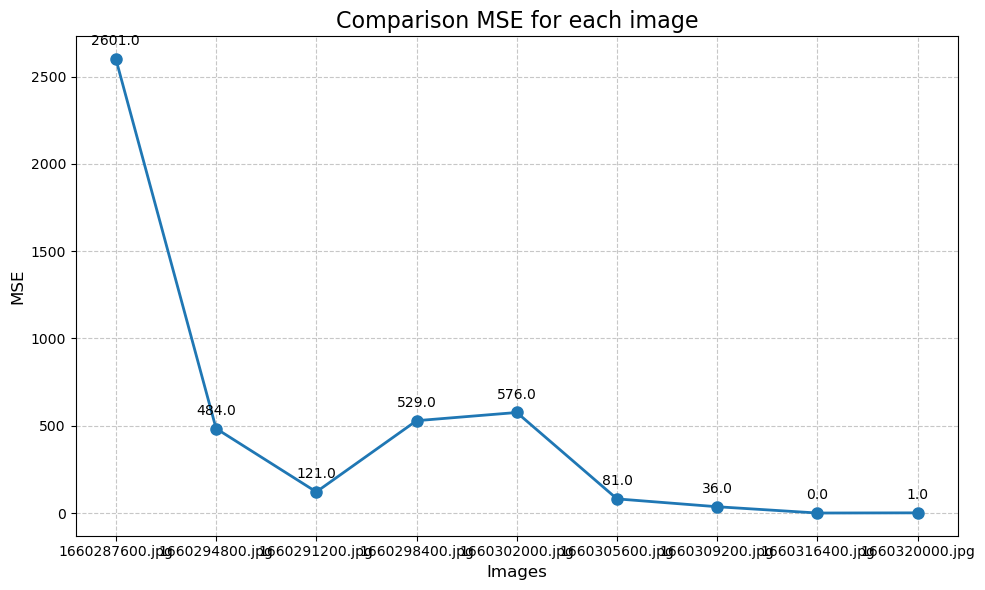

In [16]:
mse_values = [item['MSE'] for item in comparison]


plt.figure(figsize=(10, 6))
plt.plot(images, mse_values, marker='o', linestyle='-', linewidth=2, markersize=8)


plt.title('Comparison MSE for each image', fontsize=16)
plt.xlabel('Images', fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)


for i, mse in enumerate(mse_values):
    plt.annotate(f'{mse}', (images[i], mse), textcoords="offset points", xytext=(0,10), ha='center')


plt.tight_layout()
plt.show()

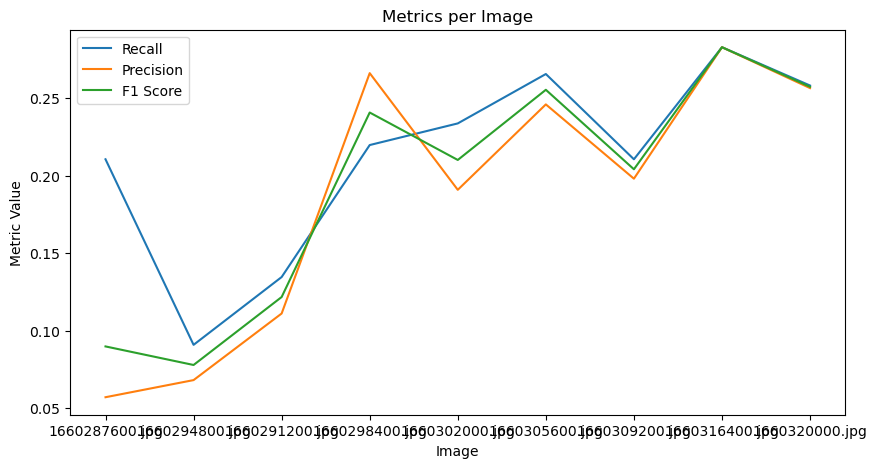

In [17]:
recall = [comp['recall'] for comp in comparison]
precision = [comp['precision'] for comp in comparison]
f1score = [comp['f1score'] for comp in comparison]
plt.figure(figsize=(10, 5))
plt.plot(images, recall, label='Recall')
plt.plot(images, precision, label='Precision')
plt.plot(images, f1score, label='F1 Score')
plt.xlabel('Image')
plt.ylabel('Metric Value')
plt.title('Metrics per Image')
plt.legend()
plt.show()